![Grounded SAM on SEM Demo](https://github.com/JingliCheng/Grounded-SEM/blob/main/assets/SEM_demo_1.png?raw=true)

## Why apply Grounded-SAM on SEM?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment new particles in SEM** with text inputs!



## Install

## Imports

In [1]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
from groundedsem.util.utils import load_model_hf, segment, draw_mask

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO


from huggingface_hub import hf_hub_download

c:\Users\fish\miniconda3\envs\groundedsem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load models

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


### Grounding DINO model

In [3]:
CKPT_REPO_ID = "ShilongLiu/GroundingDINO"
CKPT_FILENAME = "groundingdino_swinb_cogcoor.pth"
CKPT_CONFIG_FILENAME = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(CKPT_REPO_ID, CKPT_FILENAME, CKPT_CONFIG_FILENAME, DEVICE)

Config (path: C:\Users\fish\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\GroundingDINO_SwinB.cfg.py): {'batch_size': 1, 'modelname': 'groundingdino', 'backbone': 'swin_B_384_22k', 'position_embedding': 'sine', 'pe_temperatureH': 20, 'pe_temperatureW': 20, 'return_interm_indices': [1, 2, 3], 'backbone_freeze_keywords': None, 'enc_layers': 6, 'dec_layers': 6, 'pre_norm': False, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.0, 'nheads': 8, 'num_queries': 900, 'query_dim': 4, 'num_patterns': 0, 'num_feature_levels': 4, 'enc_n_points': 4, 'dec_n_points': 4, 'two_stage_type': 'standard', 'two_stage_bbox_embed_share': False, 'two_stage_class_embed_share': False, 'transformer_activation': 'relu', 'dec_pred_bbox_embed_share': True, 'dn_box_noise_scale': 1.0, 'dn_label_noise_ratio': 0.5, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'embed_init_tgt': True, 'dn_labelbook_size': 2000, 'max_text_len': 256, 'text_encoder_type': '

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Model loaded from C:\Users\fish\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [4]:
# !wget -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

SAM_CHECKPOINT = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=SAM_CHECKPOINT).to(DEVICE))

## Inference

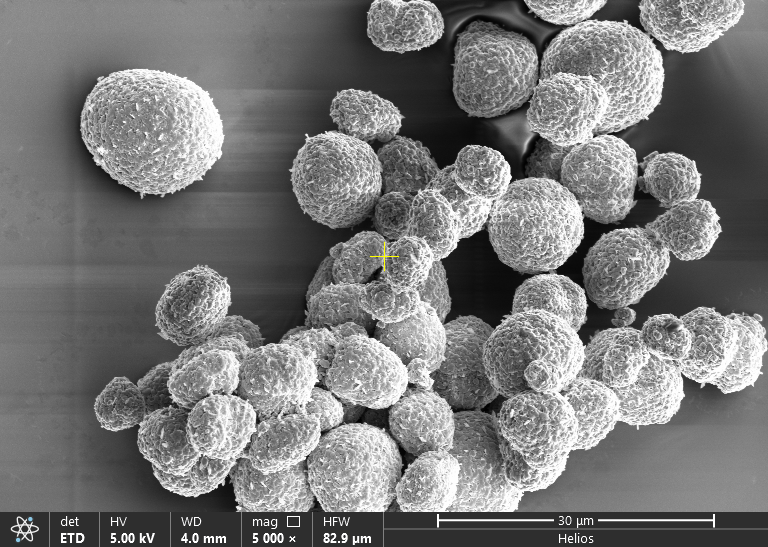

In [5]:
local_image_path = "assets/SEM/SEM_1.png"

image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [6]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.1, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


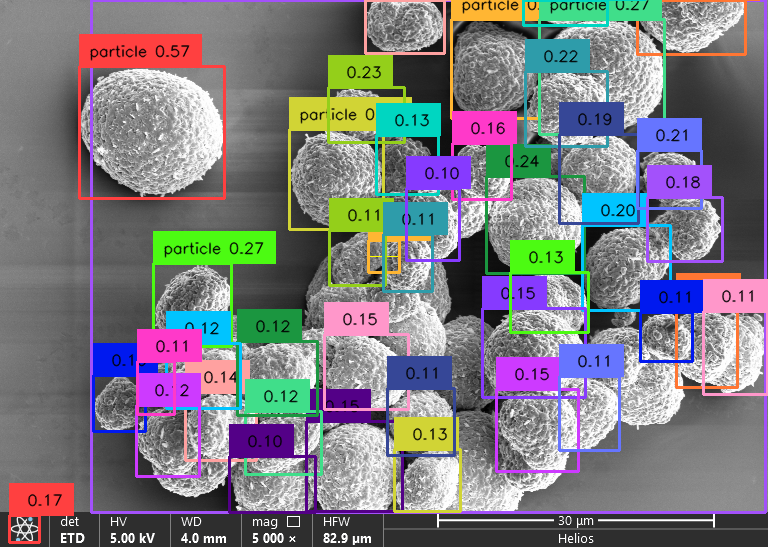

In [7]:
annotated_frame, detected_boxes = detect(image, text_prompt="particle", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

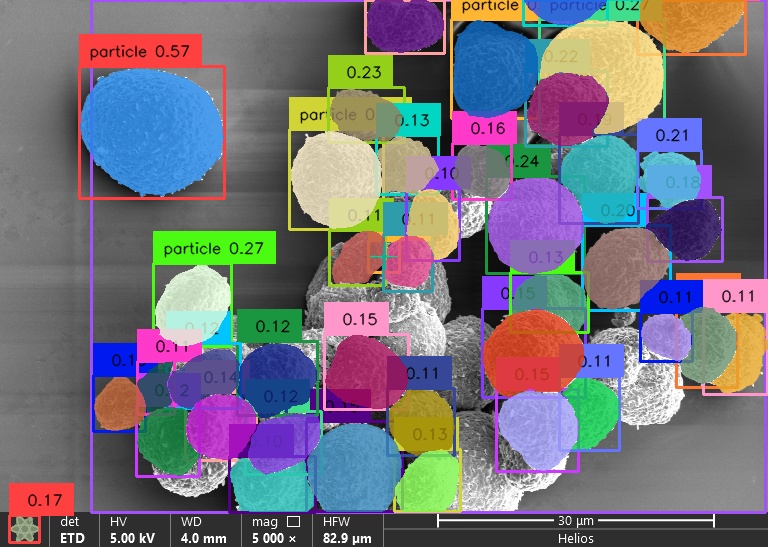

In [8]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes, device=DEVICE)
for mask in segmented_frame_masks[1:]:
  annotated_frame = draw_mask(mask[0], annotated_frame)
Image.fromarray(annotated_frame)


## TODO:
1. rename image
2. extract length
3. auto detect the bar size
4. auto resize the image for the best quality
5. auto detect overlap(based on box, not the mask)
6. auto remove outliers(should be done by 5)
7. auto find the statistics.
8. auto search prompt and threshold.